In [76]:
from gwpy.timeseries import TimeSeries

def visualize_data(data):
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 14))

    # 3. Power Spectral Density (PSD)
    psd = data.psd(fftlength=2, overlap=1)
    axes[0].loglog(psd.frequencies.value, np.sqrt(psd.value), 'g-', linewidth=1)
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes[0].set_title('Power Spectral Density')
    axes[0].set_xlim(20, 1000)
    #axes.set_ylim(ymin, ymax)
    axes[0].grid(True, alpha=0.3)

    psd = data.psd(fftlength=80, overlap=20)
    axes[1].loglog(psd.frequencies.value, np.sqrt(psd.value), 'g-', linewidth=1)
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes[1].set_title('Power Spectral Density')
    axes[1].set_xlim(57, 63)
    #axes.set_ylim(ymin, ymax)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


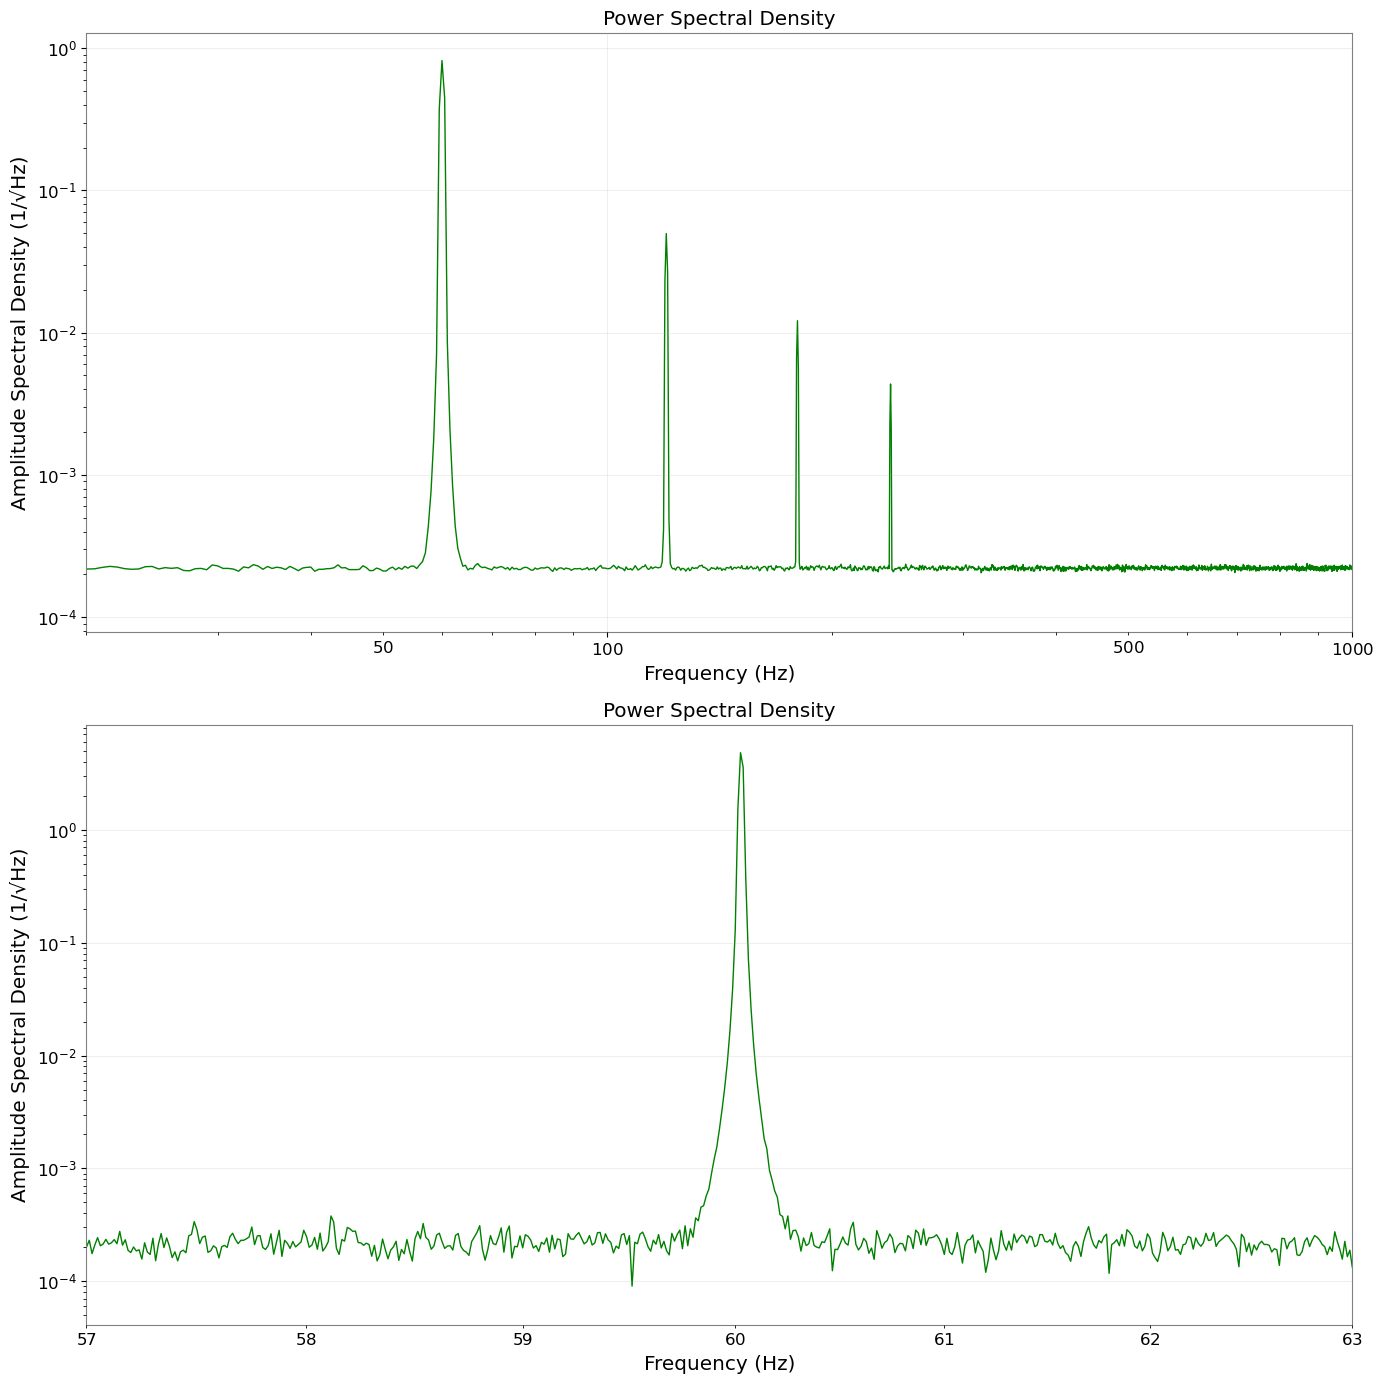

In [77]:
import numpy as np
import matplotlib.pyplot as plt
def simulate_mains_hum(f_hum=60, harmonics=4, sample_rate=4096, duration=1024):
    """
    Simulate realistic mains hum with slight frequency jitter and variable harmonic amplitudes.
    """
    t = np.arange(0, duration, 1/sample_rate)
    signal = np.zeros_like(t)
    
    for n in range(1, harmonics + 1):
        # random amplitude for each harmonic (typical real hum: fundamental strongest)
        amp = 1.0 / (n ** 4) * (0.8 + 0.4*np.random.rand())  
        
        # small random frequency fluctuation to simulate real AC power variation
        freq_jitter = f_hum * 0.001 * (np.random.rand() - 0.5)  
        signal += amp * np.sin(2 * np.pi * (f_hum*n + freq_jitter) * t)
    
    # add low-level broadband noise
    signal += 0.01 * np.random.randn(len(t))
    
    return signal
data = simulate_mains_hum()
dataTS = TimeSeries(data, unit = 's', t0 = 0, dt = 1 / 4096)


visualize_data(dataTS)

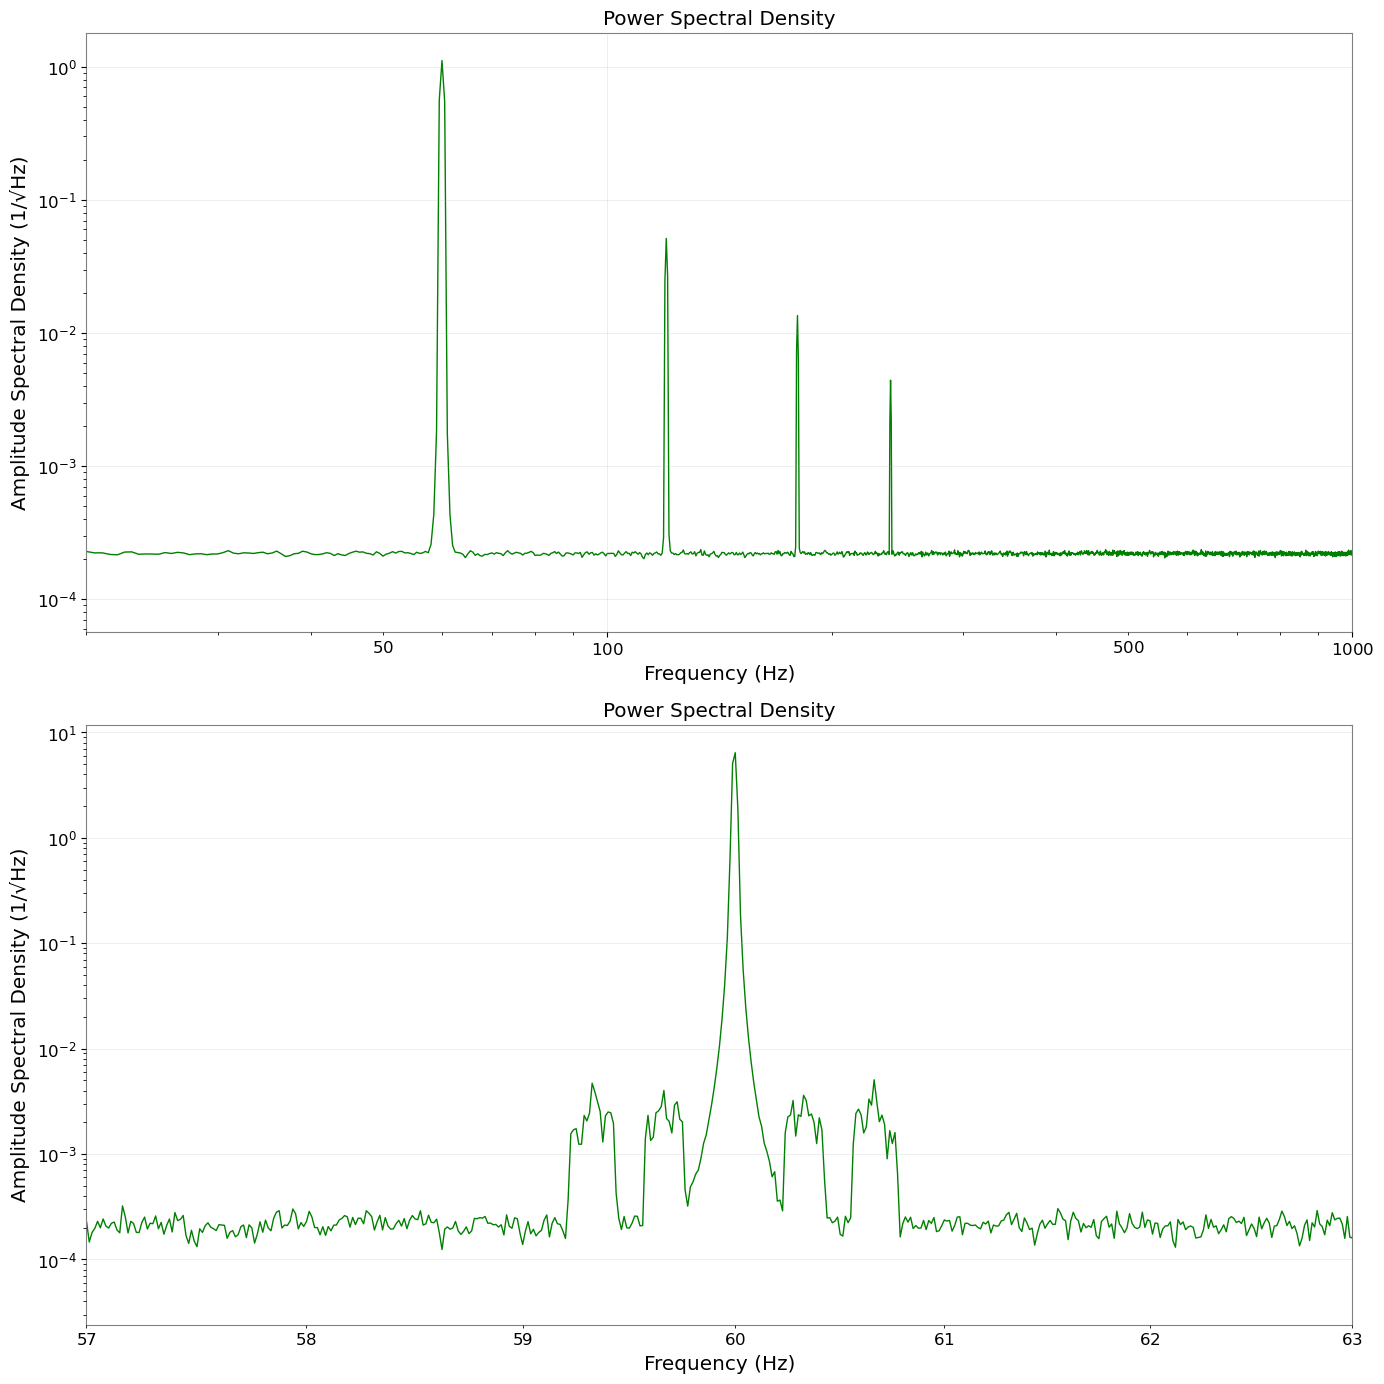

In [108]:
import random
def sideband_nonlinear_coupling(signal, sample_rate=4096):
    """
    Introduce significant sidebands around each harmonic by low-frequency amplitude modulation.
    """
    t = np.arange(len(signal)) / sample_rate
    
    # Modulation signal: multiple low-frequency sinusoids to generate visible sidebands
    mod = 0.001 * np.sin(2*np.pi*(2/3)*t) + 0.001 * np.sin(2*np.pi*(1/3)*t)
    for x in range(20):
        mod += 0.0005 * np.sin(2*np.pi*(2/3 + random.uniform(-0.1, 0.1) )*t) + 0.0005 * np.sin(2*np.pi*(1/3 + random.uniform(-0.1, 0.1) )*t)
    
    # Amplitude modulation
    modulated_signal = signal * (1 + mod)
    
    return modulated_signal

data = simulate_mains_hum()
data2 = sideband_nonlinear_coupling(data)
dataTS2 = TimeSeries(data2, unit = 's', t0 = 0, dt = 1 / 4096)

visualize_data(dataTS2)

In [109]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('..')

from src.model import DeepCleanAutoencoder
from src.dataset import GWDataset
from src.utils import postprocess

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")

TEST_DATA_PATH = '../data/train_data_raw.npz' 

data = np.load(TEST_DATA_PATH)
strain_raw = data['strain']
witnesses_raw = data['witnesses']


Running on device: cuda


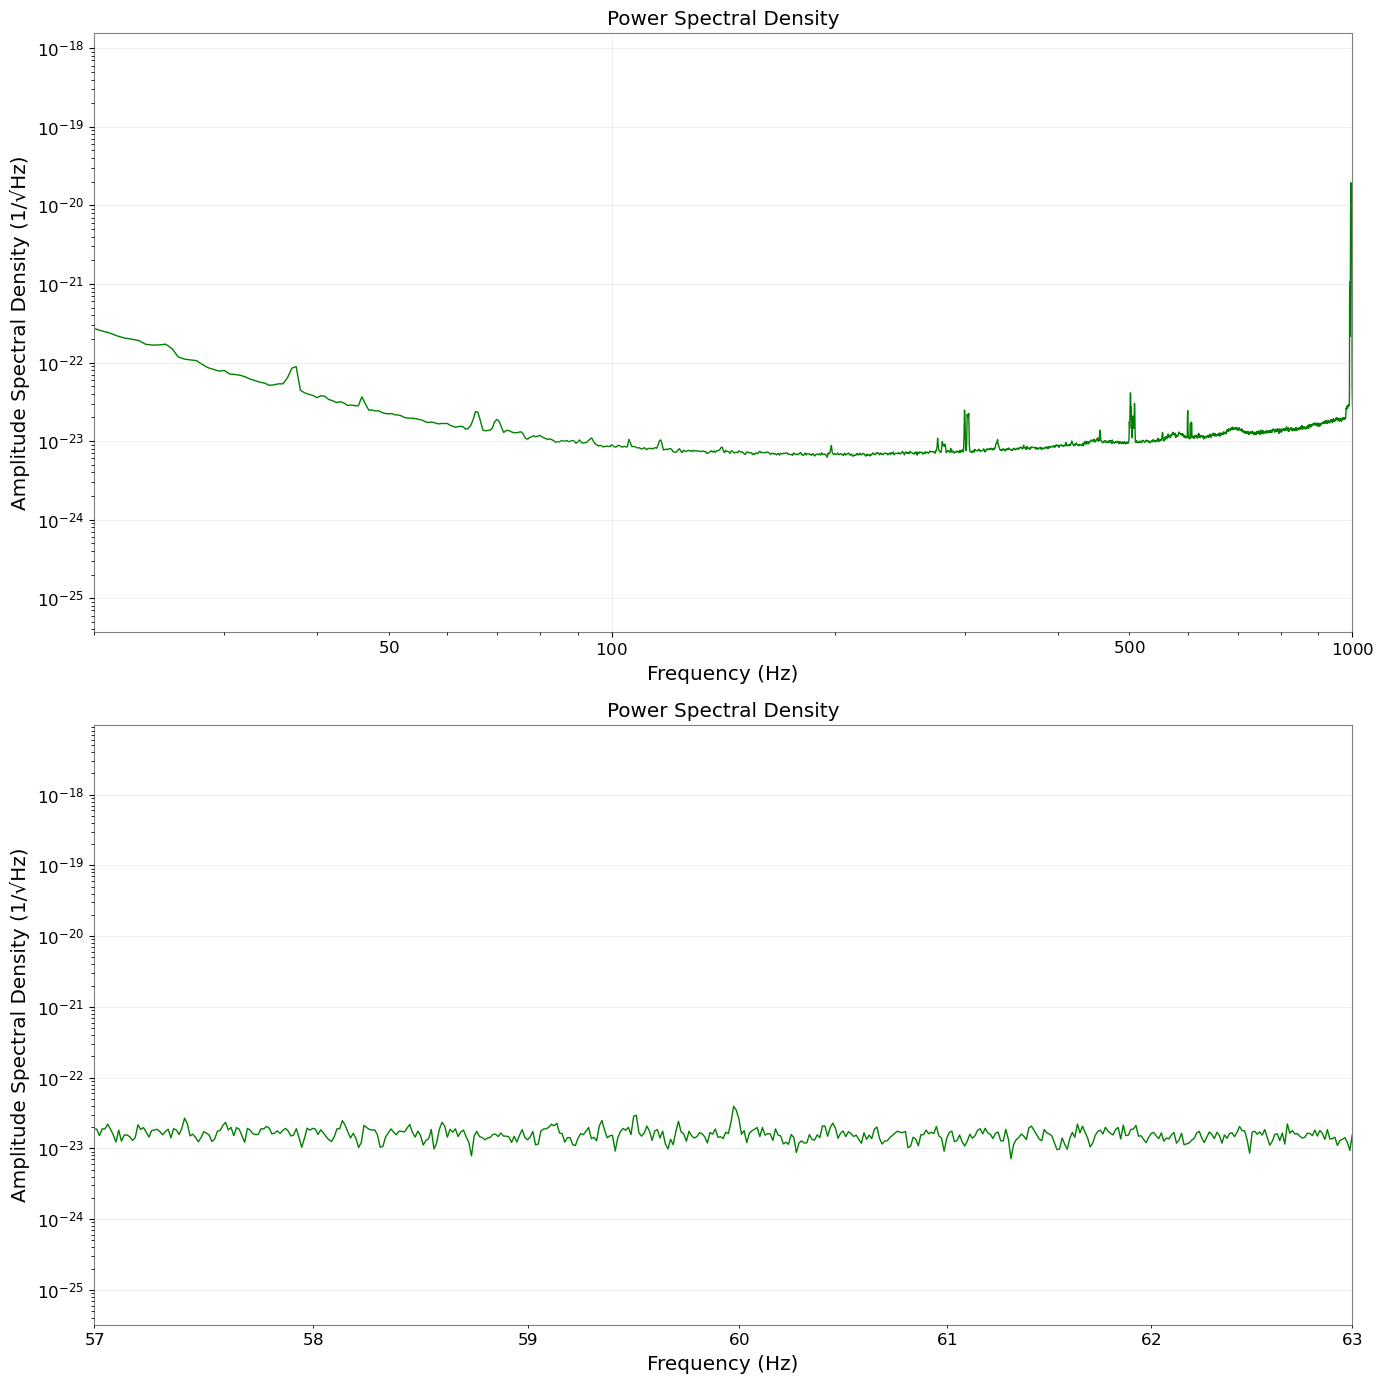

In [110]:
dataTSReal = TimeSeries(data['strain'], unit = 's', t0 = 0, dt = 1 / 4096)

visualize_data(dataTSReal)

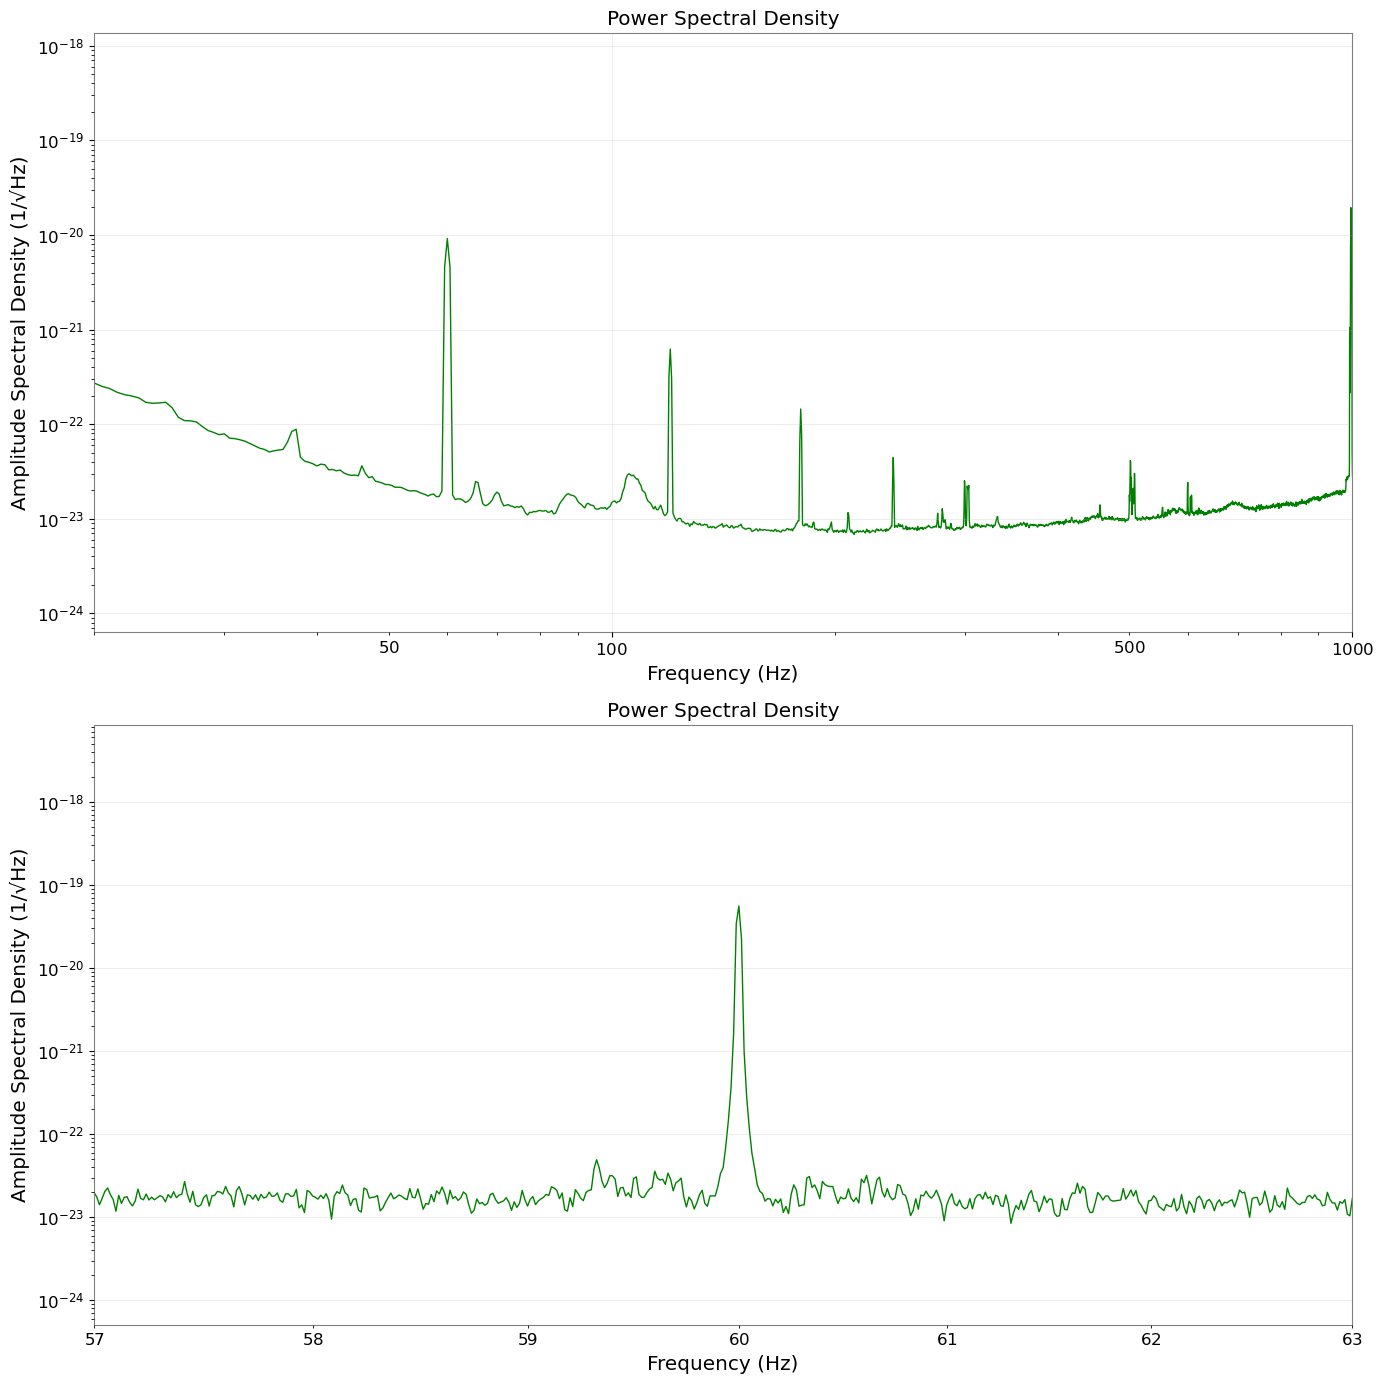

In [119]:
# mainsHumWitness = simulate_mains_hum()
modulatedNoise = sideband_nonlinear_coupling(mainsHumWitness)

simulatedNoisedData = data['strain'] + modulatedNoise * 1e-20

for i, channel in enumerate(data['witnesses']):
    channel = np.array(channel)  
    # normalize to [-1, 1]
    normalizedWitnessChannel = 2 * (channel - channel.min()) / (channel.max() - channel.min()) - 1
    simulatedNoisedData += normalizedWitnessChannel * 3e-22
    
    
simulatedData = TimeSeries(simulatedNoisedData, unit = 's', t0 = 0, dt = 1 / 4096)

visualize_data(simulatedData)